4


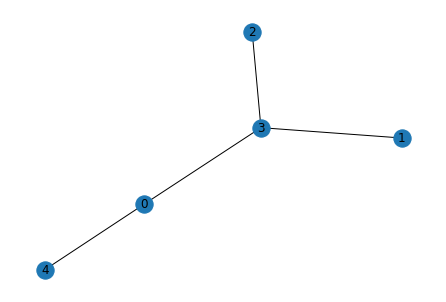

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from query_graphs.query_graphs import QueryGraphs

query_graph = QueryGraphs().get_graph_7(4)
query_graph = QueryGraphs().get_graph_8(5)
#query_graph = nx.path_graph(10)

n_joins = len(query_graph.edges) - len(nx.cycle_basis(query_graph))
max_number_of_levels = n_joins
print(max_number_of_levels)
levels = range(max_number_of_levels)

#cardinality = {}
#for node in query_graph.nodes(data=True):
#    cardinality[node[0]] = node[1]['cardinality']

#selectivity = {}
#for edge in query_graph.edges(data=True):
#    selectivity[(edge[0], edge[1])] = edge[2]['selectivity']
    
nx.draw(query_graph, with_labels=True)

In [2]:
import matplotlib.pyplot as plt
from itertools import combinations

def get_connected_subgraphs_dfs(graph, node, n):
    connected_subgraphs = set()
    
    # Function to perform DFS to find connected subgraphs of size n
    def dfs(start_node, path):
        
        if len(path) == n + 1:
            connected_subgraphs.add(tuple(path))
            return
        
        for r in range(1, n - len(path) + 2):
            for neighbors_combination in combinations(graph.neighbors(start_node), r):
                for neighbor in neighbors_combination:
                    if neighbor not in path:
                        dfs(neighbor, path.union(set(neighbors_combination)))
    
    for r in range(1, n + 1):
        for neighbors_combination in combinations(graph.neighbors(node), r):
            for neighbor in neighbors_combination:
                dfs(neighbor, set(list(neighbors_combination) + [node]))
    
    return connected_subgraphs

In [3]:
from classical_algorithms.weights_costs import basic_cost, join_tree_cardinality


class Variable:
    
    def __init__(self, query_graph, new_subgraph, subgraph, rel1, rel2, level, base_labeling):
        self.query_graph = query_graph
        self.subgraph = subgraph
        self.level = level
        self.local_cost = 1
        self.new_subgraph = new_subgraph
        
        relations = {}
        for node in query_graph.subgraph(new_subgraph).nodes(data=True):
            relations[node[0]] = node[1]

        selectivity = dict()
        for edge in query_graph.subgraph(new_subgraph).edges(data=True):
            selectivity[(edge[0], edge[1])] = edge[2]
        
        tables = list(relations.keys())
        join_tree = [tables[0], tables[1]]
        for rel in tables[2:]:
            join_tree = [rel, join_tree]

        self.local_cost = join_tree_cardinality(join_tree, relations, selectivity)
        
        self.labeling = base_labeling + [(rel1, rel2, level)]
        self.rel1 = rel1
        self.rel2 = rel2
        
    def get_labeling(self):
        return self.labeling
    
    def get_local_cost(self):
        return self.local_cost
    
    def __str__(self) -> str:
        return f'Variable({self.rel1}, {self.rel2}, {self.level}) with labelings {self.labeling} and local cost {self.local_cost}'

In [4]:
variables = {}
#all_connected_subgraphs = set()

for level in levels:
    for edge in query_graph.edges(data=True):
        
        if level == 0:
            subgraph = frozenset([edge[0], edge[1]])
            variables[subgraph] = [Variable(query_graph, subgraph, subgraph, edge[0], edge[1], level, [])]
        else:
            join1 = edge[0]
            join2 = edge[1]
            
            query_graph_copy = query_graph.copy()
            edge_to_remove = (join1, join2)
            query_graph_copy.remove_edge(*edge_to_remove)
            
            connected_subgraphs = get_connected_subgraphs_dfs(query_graph_copy, join1, level)
            connected_subgraphs = connected_subgraphs.union(get_connected_subgraphs_dfs(query_graph_copy, join2, level))
            
            #print("Join: ", edge)
            #print("Level: ", level)
            #print(connected_subgraphs)
            #all_connected_subgraphs = all_connected_subgraphs.union(connected_subgraphs)
            
            for subgraph in connected_subgraphs:
                new_subgraph = frozenset(subgraph + (join1, join2))
                subgraph = frozenset(subgraph)
                #print(variables)
                if new_subgraph not in variables:
                    variables[new_subgraph] = []
                    
                for var in variables[subgraph]:
                    variables[new_subgraph].append(Variable(query_graph, new_subgraph, subgraph, join1, join2, level, var.get_labeling()))

[0] [3]
0 3 0.4236547993389047
10.167715184133712
[0] [4]
0 4 0.6458941130666561
31.002917427199492
[1] [3]
1 3 0.4375872112626925
1.75034884505077
[2] [3]
2 3 0.8917730007820798
14.268368012513276
[3] [0, 2]
0 3 0.4236547993389047
2 3 0.8917730007820798
[0] [2]
24
36.26917552340975
[3] [0, 1]
0 3 0.4236547993389047
1 3 0.4375872112626925
[0] [1]
6
4.449262132338406
[4] [0, 3]
0 4 0.6458941130666561
[0] [3]
0 3 0.4236547993389047
10.167715184133712
52.53813904616333
[4] [0, 3]
0 4 0.6458941130666561
[0] [3]
0 3 0.4236547993389047
10.167715184133712
52.53813904616333
[3] [1, 2]
1 3 0.4375872112626925
2 3 0.8917730007820798
[1] [2]
4
6.243655367865491
[3] [0, 1]
0 3 0.4236547993389047
1 3 0.4375872112626925
[0] [1]
6
4.449262132338406
[3] [0, 2]
0 3 0.4236547993389047
2 3 0.8917730007820798
[0] [2]
24
36.26917552340975
[3] [1, 2]
1 3 0.4375872112626925
2 3 0.8917730007820798
[1] [2]
4
6.243655367865491
[3] [2, 0, 1]
2 3 0.8917730007820798
0 3 0.4236547993389047
1 3 0.4375872112626925
[2]

In [5]:
for v in variables:
    print(v)
    for var in variables[v]:
        print(var)

frozenset({0, 3})
Variable(0, 3, 0) with labelings [(0, 3, 0)] and local cost 10.167715184133712
frozenset({0, 4})
Variable(0, 4, 0) with labelings [(0, 4, 0)] and local cost 31.002917427199492
frozenset({1, 3})
Variable(1, 3, 0) with labelings [(1, 3, 0)] and local cost 1.75034884505077
frozenset({2, 3})
Variable(2, 3, 0) with labelings [(2, 3, 0)] and local cost 14.268368012513276
frozenset({0, 2, 3})
Variable(0, 3, 1) with labelings [(2, 3, 0), (0, 3, 1)] and local cost 36.26917552340975
Variable(2, 3, 1) with labelings [(0, 3, 0), (2, 3, 1)] and local cost 36.26917552340975
frozenset({0, 1, 3})
Variable(0, 3, 1) with labelings [(1, 3, 0), (0, 3, 1)] and local cost 4.449262132338406
Variable(1, 3, 1) with labelings [(0, 3, 0), (1, 3, 1)] and local cost 4.449262132338406
frozenset({0, 3, 4})
Variable(0, 3, 1) with labelings [(0, 4, 0), (0, 3, 1)] and local cost 52.53813904616333
Variable(0, 4, 1) with labelings [(0, 3, 0), (0, 4, 1)] and local cost 52.53813904616333
frozenset({1, 2, 

In [6]:
import dimod

def variables_to_dict(variables):
    variables_dict = {}
    for v in variables:
        for var in variables[v]:
            labeling = var.get_labeling()
            variables_dict[tuple(labeling)] = var.get_local_cost()
    return variables_dict


var_dict = variables_to_dict(variables)
print(var_dict)

{((0, 3, 0),): 10.167715184133712, ((0, 4, 0),): 31.002917427199492, ((1, 3, 0),): 1.75034884505077, ((2, 3, 0),): 14.268368012513276, ((2, 3, 0), (0, 3, 1)): 36.26917552340975, ((0, 3, 0), (2, 3, 1)): 36.26917552340975, ((1, 3, 0), (0, 3, 1)): 4.449262132338406, ((0, 3, 0), (1, 3, 1)): 4.449262132338406, ((0, 4, 0), (0, 3, 1)): 52.53813904616333, ((0, 3, 0), (0, 4, 1)): 52.53813904616333, ((2, 3, 0), (1, 3, 1)): 6.243655367865491, ((1, 3, 0), (2, 3, 1)): 6.243655367865491, ((2, 3, 0), (1, 3, 1), (0, 3, 2)): 15.87092737208598, ((1, 3, 0), (2, 3, 1), (0, 3, 2)): 15.87092737208598, ((2, 3, 0), (0, 3, 1), (1, 3, 2)): 15.87092737208598, ((0, 3, 0), (2, 3, 1), (1, 3, 2)): 15.87092737208598, ((1, 3, 0), (0, 3, 1), (2, 3, 2)): 15.87092737208598, ((0, 3, 0), (1, 3, 1), (2, 3, 2)): 15.87092737208598, ((1, 3, 0), (0, 3, 1), (0, 4, 2)): 22.99001775014219, ((0, 3, 0), (1, 3, 1), (0, 4, 2)): 22.99001775014219, ((0, 4, 0), (0, 3, 1), (1, 3, 2)): 22.99001775014219, ((0, 3, 0), (0, 4, 1), (1, 3, 2)): 

In [7]:
# At every level we perform exactly one join
hubo = dimod.BinaryPolynomial(var_dict, dimod.Vartype.BINARY)
hubo_total_cost = dimod.BinaryPolynomial(var_dict, dimod.Vartype.BINARY)
hubo.normalize()
hubo_variables = hubo.variables
var_dict, off = hubo.to_hubo()
#var_dict = {}

variables_by_levels = {}
for level in levels:
    variables_by_levels[level] = []
    for v in hubo_variables:
        if v[2] == level:
            variables_by_levels[level].append(v)
            
#print(variables_by_levels)

for l in variables_by_levels:
    vars = variables_by_levels[l]
    bqm = dimod.generators.combinations(vars, 1, strength=2)
    for bvar in bqm.linear:
        if (bvar,) in var_dict:
            var_dict[(bvar,)] = bqm.linear[bvar] + var_dict[(bvar,)]
        else:
            var_dict[(bvar,)] = bqm.linear[bvar]
    for bvar in bqm.quadratic:
        if bvar in var_dict:
            var_dict[bvar] = bqm.quadratic[bvar] + var_dict[bvar]
        else:
            var_dict[bvar] = bqm.quadratic[bvar]           


In [8]:
# Encode (1 - labelings for variables[frozenset({0, 1, 2, 3, 4})])^2
# (1 - x - y - z)^2 = x^2 + 2 x y + 2 x z - 2 x + y^2 + 2 y z - 2 y + z^2 - 2 z + 1
# = -x - y - z + 2 x y + 2 x z + 2 y z + 1
offset = 1
scaler = 2
labelings_for_full_join = [var.get_labeling() for var in variables[frozenset(query_graph.nodes)]]
print(labelings_for_full_join)
for labeling in labelings_for_full_join:
    
    if tuple(labeling) in var_dict:
        var_dict[tuple(labeling)] = var_dict[tuple(labeling)] - 1*scaler
    else:
        print(tuple(labeling))
        var_dict[tuple(labeling)] = -1*scaler
        
for comb in combinations(labelings_for_full_join, 2):
    prod = tuple(comb[0] + comb[1])
    print(prod)
    if prod in var_dict:
        var_dict[prod] = var_dict[prod] + 2*scaler
    else:
        var_dict[prod] = 2*scaler

[[(2, 3, 0), (1, 3, 1), (0, 3, 2), (0, 4, 3)], [(1, 3, 0), (2, 3, 1), (0, 3, 2), (0, 4, 3)], [(2, 3, 0), (0, 3, 1), (1, 3, 2), (0, 4, 3)], [(0, 3, 0), (2, 3, 1), (1, 3, 2), (0, 4, 3)], [(1, 3, 0), (0, 3, 1), (2, 3, 2), (0, 4, 3)], [(0, 3, 0), (1, 3, 1), (2, 3, 2), (0, 4, 3)], [(2, 3, 0), (0, 3, 1), (0, 4, 2), (1, 3, 3)], [(0, 3, 0), (2, 3, 1), (0, 4, 2), (1, 3, 3)], [(0, 4, 0), (0, 3, 1), (2, 3, 2), (1, 3, 3)], [(0, 3, 0), (0, 4, 1), (2, 3, 2), (1, 3, 3)], [(1, 3, 0), (0, 3, 1), (0, 4, 2), (2, 3, 3)], [(0, 3, 0), (1, 3, 1), (0, 4, 2), (2, 3, 3)], [(0, 4, 0), (0, 3, 1), (1, 3, 2), (2, 3, 3)], [(0, 3, 0), (0, 4, 1), (1, 3, 2), (2, 3, 3)]]
((2, 3, 0), (1, 3, 1), (0, 3, 2), (0, 4, 3))
((1, 3, 0), (2, 3, 1), (0, 3, 2), (0, 4, 3))
((2, 3, 0), (0, 3, 1), (1, 3, 2), (0, 4, 3))
((0, 3, 0), (2, 3, 1), (1, 3, 2), (0, 4, 3))
((1, 3, 0), (0, 3, 1), (2, 3, 2), (0, 4, 3))
((0, 3, 0), (1, 3, 1), (2, 3, 2), (0, 4, 3))
((2, 3, 0), (0, 3, 1), (0, 4, 2), (1, 3, 3))
((0, 3, 0), (2, 3, 1), (0, 4, 2), (1, 3,

In [9]:
hubo = dimod.BinaryPolynomial(var_dict, dimod.Vartype.BINARY)
print(hubo)
#hubo.normalize()
solver = dimod.ExactPolySolver()
result = solver.sample_poly(hubo)
print(result.first.energy)
for res in result.first.sample:
    if result.first.sample[res] == 1:
        print(res)
        
#for i, datum in enumerate(result.lowest()):  
#    print("Datum: ", i)
#    for res in datum:
#        if datum[res] == 1:
#            print(res)

BinaryPolynomial({frozenset({(0, 3, 0)}): -1.945745673592099, frozenset({(0, 4, 0)}): -1.8345702676332598, frozenset({(1, 3, 0)}): -1.9906602421638182, frozenset({(2, 3, 0)}): -1.9238648328124957, frozenset({(0, 3, 1), (2, 3, 0)}): 0.19353017386473692, frozenset({(2, 3, 1), (0, 3, 0)}): 0.19353017386473692, frozenset({(1, 3, 0), (0, 3, 1)}): 0.023740999391769217, frozenset({(1, 3, 1), (0, 3, 0)}): 0.023740999391769217, frozenset({(0, 3, 1), (0, 4, 0)}): 0.2803404002820801, frozenset({(0, 3, 0), (0, 4, 1)}): 0.2803404002820801, frozenset({(1, 3, 1), (2, 3, 0)}): 0.033315775488598924, frozenset({(1, 3, 0), (2, 3, 1)}): 0.033315775488598924, frozenset({(1, 3, 1), (0, 3, 2), (2, 3, 0)}): 0.08468632907665426, frozenset({(1, 3, 0), (2, 3, 1), (0, 3, 2)}): 0.08468632907665426, frozenset({(1, 3, 2), (0, 3, 1), (2, 3, 0)}): 0.08468632907665426, frozenset({(2, 3, 1), (1, 3, 2), (0, 3, 0)}): 0.08468632907665426, frozenset({(1, 3, 0), (2, 3, 2), (0, 3, 1)}): 0.08468632907665426, frozenset({(2, 3, 

In [12]:
test_point = {v: 0 for v in hubo_total_cost.variables}
test_point[(0, 3, 1)] = 1
test_point[(0, 4, 3)] = 1
test_point[(1, 3, 0)] = 1
test_point[(2, 3, 2)] = 1
print(hubo_total_cost.energy(test_point))

104.07804681778548


In [13]:
import numpy as np

for v, value in hubo_total_cost.to_hubo()[0].items():
    if np.all([v1 in [(0, 3, 1), (0, 4, 3), (1, 3, 0), (2, 3, 2)] for v1 in v]):
        print(v, value)

((1, 3, 0),) 1.75034884505077
((1, 3, 0), (0, 3, 1)) 4.449262132338406
((1, 3, 0), (2, 3, 2), (0, 3, 1)) 15.87092737208598
((1, 3, 0), (2, 3, 2), (0, 3, 1), (0, 4, 3)) 82.00750846831032
